In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from scipy.optimize import curve_fit
from joblib import Parallel, delayed


# ----------------------------------------------------------------
# 1. Basic functions
# ----------------------------------------------------------------

def generate_hppp(lambda_intensity, space_range):
    """Generate points from a 2D homogeneous Poisson point process (HPPP)."""
    area = space_range**2
    num_points = np.random.poisson(lambda_intensity * area)

    x_coords = np.random.uniform(-space_range/2, space_range/2, num_points)
    y_coords = np.random.uniform(-space_range/2, space_range/2, num_points)
    return np.column_stack((x_coords, y_coords))

def calculate_max_eavesdropper_snr(eavesdropper_density, space_range, alpha):
    """ Evaluate the maximum SNR of randomly placed eavesdroppers in a single experiment. """
    points = generate_hppp(eavesdropper_density, space_range)
    if len(points) == 0:
        return 0.0
    distances = np.linalg.norm(points, axis=1)
    # 도청자 채널 g ~ Exponential(1), 경로손실 d^-α
    snrs = np.random.exponential(scale=1.0, size=len(distances)) / distances**alpha
    return np.max(snrs)

def single_experiment(eavesdropper_density, space_range, alpha, legit_distance):
    """
    단일 시뮬레이션 실험:
      - 도청자들 중 최댓값의 SNR vs. 합법 단말 SNR 비교
      - legit_snr > max_eve_snr 이면 1, 아니면 0
    """
    max_eve_snr = calculate_max_eavesdropper_snr(eavesdropper_density, space_range, alpha)
    legit_snr = np.random.exponential(scale=1.0) / (legit_distance**alpha)
    return int(legit_snr > max_eve_snr)

def simulate_spsc_vs_density_parallel(density_list, space_range, alpha, legit_distance,
                                      num_experiment=10000, n_jobs=-1, verbose=False):
    """
    밀도(density_list)에 따라 (kappa, SPSC)를 얻는다.
    kappa = pi * lambda * gamma(1-2/alpha)*gamma(1+2/alpha).
    """
    from scipy.special import gamma

    kappa_list = []
    spsc_list = []

    for idx, eavesdropper_density in enumerate(density_list):
        kappa = (np.pi * eavesdropper_density
                 * gamma(1 - 2/alpha) * gamma(1 + 2/alpha))
        kappa_list.append(kappa)

        results = Parallel(n_jobs=n_jobs)(
            delayed(single_experiment)(eavesdropper_density, space_range, alpha, legit_distance)
            for _ in range(num_experiment)
        )
        spsc_est = np.mean(results)
        spsc_list.append(spsc_est)

        if verbose:
            print(f"{idx} | density={eavesdropper_density:.2e}, SPSC={spsc_est:.4f}")

    return np.array(kappa_list), np.array(spsc_list)

# ----------------------------------------------------------------
# 2. Approx model & fitting
# ----------------------------------------------------------------

def approximated_SPSC_prob(kappa, distance, a=1.0, p=1.0):
    """
    SPSC(d, kappa) ≈ exp(- a * (kappa^p) * distance^2).
    """
    return np.exp(- a * (kappa**p) * distance**2)

def fit_power_kappa(kappa_array, spsc_array, distance):
    """
    distance 고정해놓고,
    SPSC ≈ exp(- a*(kappa^p)*distance^2 ) 모델에 대하여 (a, p) 추정.
    """
    def _model_func(kappa_, a_, p_):
        return approximated_SPSC_prob(kappa_, distance, a_, p_)

    popt, pcov = curve_fit(
        _model_func,
        kappa_array,
        spsc_array,
        p0=[1.0, 1.0],
        bounds=([0, 0], [np.inf, np.inf])
    )
    return popt  # (a, p)


=== 전역 피팅 결과 ===
a=0.2969, p=0.9386


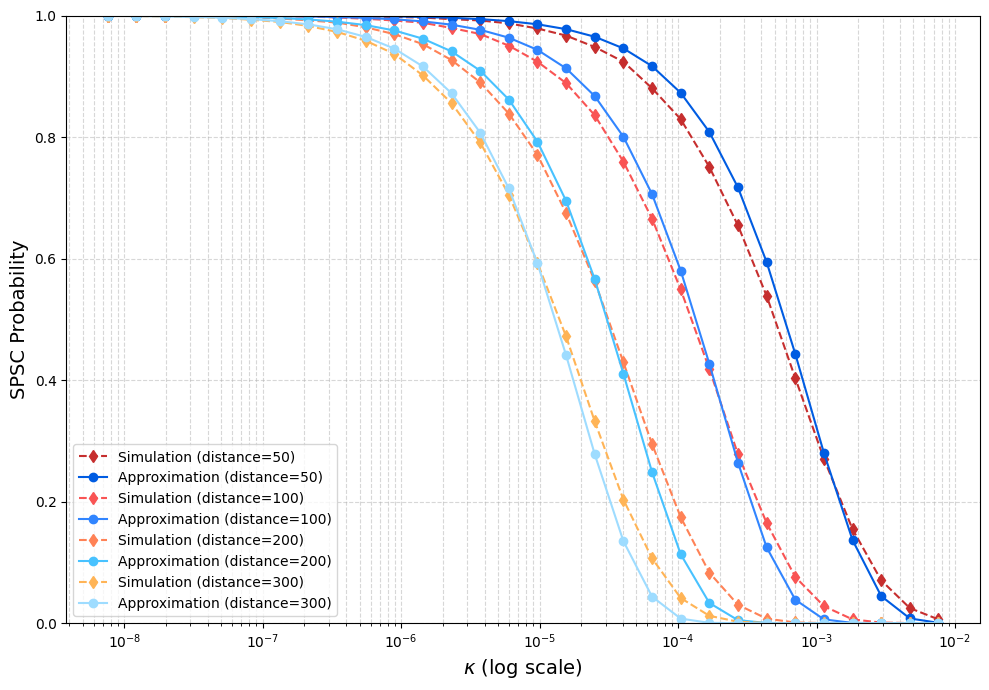

In [10]:
def multi_distance_fit(all_results):
    """
    all_results: {distance: {"kappa":..., "spsc":...}, ...}
      - 이미 시뮬레이션된 kappa_array, spsc_array를 거리별로 저장해둔 dict

    모든 거리(d)에 대해 (kappa_array, spsc_array)를 합쳐서
    SPSC(d, kappa) ≈ exp(-a*(kappa^p)*d^2 ) 형태로 curve_fit 수행.

    return: (a, p)
    """

    # (1) 모든 (kappa, distance) 짝과 spsc 값을 모은다.
    big_x = []
    big_y = []
    for d, val_dict in all_results.items():
        kappa_array = val_dict["kappa"]
        spsc_array = val_dict["spsc"]
        for i in range(len(kappa_array)):
            big_x.append([kappa_array[i], d])
            big_y.append(spsc_array[i])

    big_x = np.array(big_x)  # shape: (N,2), N= (거리개수)*(kappa개수)
    big_y = np.array(big_y)  # shape: (N,)

    # (2) 피팅에 사용할 모델 함수 정의
    def _model_func(x2d, a_, p_):
        # x2d: shape=(N,2)
        kappa_ = x2d[:, 0]
        dist_  = x2d[:, 1]
        return np.exp(-a_ * (kappa_**p_) * (dist_**2))

    # (3) curve_fit 실행
    popt, pcov = curve_fit(
        _model_func,
        big_x, big_y,
        p0=[1.0, 1.0],
        bounds=([0, 0], [np.inf, np.inf])
    )

    return popt  # (a, p)


# (앞선 코드와 동일) 시뮬레이션 수행
np.random.seed(0)
alpha = 3.0  # pathloss exponent
space_range = 5000
num_experiment = 50000
density_list = np.logspace(-9, -3, 30)  # log-scale eavesdropper density
distance_array = np.array([50, 100, 200, 300])  # legitimate distance

all_results = {}
for d in distance_array:
    kappa_array, spsc_array = simulate_spsc_vs_density_parallel(
        density_list, space_range, alpha, d,
        num_experiment=num_experiment, n_jobs=-1, verbose=False
    )
    all_results[d] = {
        "kappa": kappa_array,
        "spsc": spsc_array
    }

# -----------------------------
# (B) 전역 피팅: 모든 거리 데이터로 (a, p) 한 쌍 추정
# -----------------------------
a_global, p_global = multi_distance_fit(all_results)
print(f"\n=== 전역 피팅 결과 ===")
print(f"a={a_global:.4f}, p={p_global:.4f}")

# -----------------------------
# (C) 시뮬레이션 vs. 전역 피팅 모델 비교
# -----------------------------
plt.figure(figsize=(10, 7))

colors_red = np.array([
    [198, 46, 46],
    [249, 84, 84],
    [255, 130, 86],
    [255, 180, 86],
]) / 255.
colors_blue = np.array([
    [0, 92, 226],
    [49, 133, 255],
    [72, 194, 255],
    [158, 220, 255],
]) / 255.

for i, d in enumerate(distance_array):
    kappa_array = all_results[d]["kappa"]
    spsc_array = all_results[d]["spsc"]

    # 전역 피팅된 (a_global, p_global)을 사용한 근사 SPSC
    spsc_approx_global = approximated_SPSC_prob(kappa_array, d, a_global, p_global)

    plt.plot(kappa_array, spsc_array,
             label=f"Simulation (distance={d:.0f})",
             marker='d',
             color=colors_red[i],
             linestyle='--', 
             )
    plt.plot(kappa_array, spsc_approx_global,
             label=f"Approximation (distance={d:.0f})",
             marker='o', 
             color=colors_blue[i],)

plt.xscale('log')
plt.xlabel(r'$\kappa$ (log scale)', fontsize=14)
plt.ylabel('SPSC Probability', fontsize=14)
plt.ylim([0, 1])
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()